# EDA for Abl Kinase

Prior to our virtual screening, it's very important to explore our data first. For chemists, we can use RDkit to visualize what our dataset looks like and make any inference. This will help us on drug design later on during virtual screening process. 


Dataset can be found here: 
http://dude.docking.org/targets/abl1


## Importing Necessary Package

In [0]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

In [0]:
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

from IPython.display import Image
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops 

import pandas as pd
from pandas import concat
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
import seaborn as sns

## Active Molecules

This section will describe loading our dataframe and exploring our active molecules. 

In [0]:
active_df= pd.read_csv("actives_final.ism", header= None, sep=" ")
print(active_df.head)

<bound method NDFrame.head of                                                      0       1              2
0    Cc4cc(c1cc(O)ccc1Cl)cc5nnc(Nc3ccc(CCCN2CCCC2)c...  416908   CHEMBL250213
1    CN(CCN1CCCC1)S(=O)(=O)c5ccc(Nc4nnc3cc(c2cc(O)c...  416918   CHEMBL250019
2    CN5CCN(Cc4ccc(NC(=O)c3ccc(C)c(C#Cc1cnc2cccnn12...  649637  CHEMBL1171837
3    COc4cc(Nc2c(C#N)cnc3cc(\C=C\CCN1CCN(C)CC1)c(OC...  629071  CHEMBL1088240
4    COc5cc(Nc3c(C#N)cnc4cc(c2coc(CN1CCN(C)CC1)c2)c...  365326   CHEMBL219557
..                                                 ...     ...            ...
177                 Clc3ccc(c2cnc(NC(=O)c1cccs1)s2)cc3  489664   CHEMBL476515
178  CN(C)CCNC(=O)\C=C\c3ccc(\C=c2/oc1ccccc1n(C)c2=...  456297   CHEMBL455404
179  CN(Cc1ccccc1NC(=O)Nc4ccc(C)c(Nc3nccc(c2cccnc2)...  311059   CHEMBL365277
180          CSc4nc(N1CCCCC1)c3cnn(CC(Br)c2ccccc2)c3n4  455215   CHEMBL455164
181       Cc2ccc(NC(=O)N1CCCCC1)cc2Nc4nccc(c3cccnc3)n4  311052   CHEMBL185775

[182 rows x 3 columns]>


Looking at our dataframe above, we can see that the our dataframe contains SMILES and its corresponding CHEMBL ID. There are 182 known active compounds for Abl kinase.

In [0]:
#Assigning the name of the columsn and create a new column to indicate that 
#compounds are active
active_rows, active_cols= active_df.shape
active_df.columns= ["Smiles", "ID", "ChEMBL_ID"]
active_df["label"]= ["Active"]*active_rows

,Smiles,ID,ChEMBL_ID,label,Mol
0,Cc4cc(c1cc(O)ccc1Cl)cc5nnc(Nc3ccc(CCCN2CCCC2)c...,416908,CHEMBL250213,Active,
1,CN(CCN1CCCC1)S(=O)(=O)c5ccc(Nc4nnc3cc(c2cc(O)c...,416918,CHEMBL250019,Active,
2,CN5CCN(Cc4ccc(NC(=O)c3ccc(C)c(C#Cc1cnc2cccnn12...,649637,CHEMBL1171837,Active,
3,COc4cc(Nc2c(C#N)cnc3cc(\C=C\CCN1CCN(C)CC1)c(OC...,629071,CHEMBL1088240,Active,
4,COc5cc(Nc3c(C#N)cnc4cc(c2coc(CN1CCN(C)CC1)c2)c...,365326,CHEMBL219557,Active,

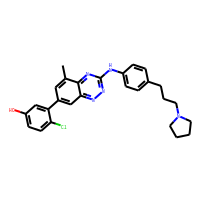
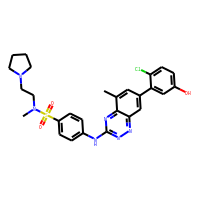
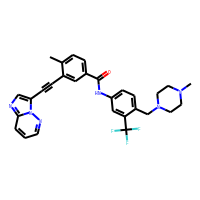
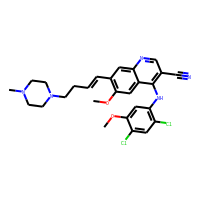
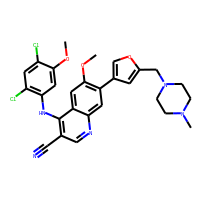

In [0]:
PandasTools.AddMoleculeColumnToFrame(active_df, "Smiles", "Mol")
#Visualizing our active compounds
active_df.head(5)

Just by glancing our first 5 compunds, we can kind of see that a lot of the active molecules have aromatic scaffold and polar residues (chlorine, methoxy, trifluoro, cyano). We can cluster our molecules using Butina clustering and then create a similarity map to make more inference

In [0]:
#Butina Cluster. Our cutoff is 0.9 but can be adjusted as little or as much
#as possible, we want to make sure that our molecules are as similar as possible
#Helper code comes from the book: "Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More"
def butina_cluster(mol_list, cutoff=0.9):
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        dists.extend([1-x for x in sims])
    mol_clusters = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    cluster_id_list = [0]*nfps
    for idx,cluster in enumerate(mol_clusters,1):
        for member in cluster:
            cluster_id_list[member] = idx
    return cluster_id_list

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Smiles,Mol,Cluster
0,Cc4cc(c1cc(O)ccc1Cl)cc5nnc(Nc3ccc(CCCN2CCCC2)c...,,1
1,CN(CCN1CCCC1)S(=O)(=O)c5ccc(Nc4nnc3cc(c2cc(O)c...,,1
2,CN5CCN(Cc4ccc(NC(=O)c3ccc(C)c(C#Cc1cnc2cccnn12...,,1
3,COc4cc(Nc2c(C#N)cnc3cc(\C=C\CCN1CCN(C)CC1)c(OC...,,1
4,COc5cc(Nc3c(C#N)cnc4cc(c2coc(CN1CCN(C)CC1)c2)c...,,1

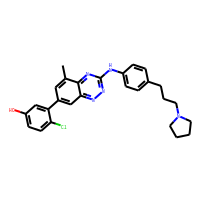
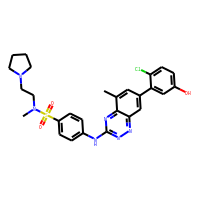
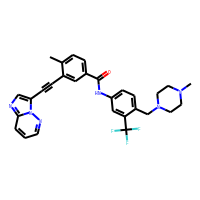
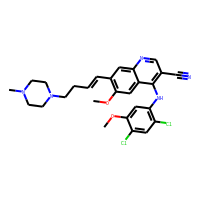
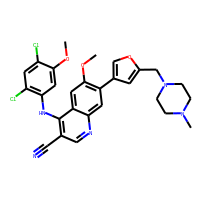

In [0]:
new_df= active_df[["Smiles", "Mol"]]
new_df["Cluster"]= butina_cluster(new_df.Mol)
new_df.head(5)

In [0]:
len(new_df["Cluster"].unique()) #There are 9 unique clusters 

9

,Smiles,Mol,Cluster
0,Cc4cc(c1cc(O)ccc1Cl)cc5nnc(Nc3ccc(CCCN2CCCC2)c...,,1
33,COc6cc5[nH]nc(c4nc3cc(N2CCC(N1CCCCC1)CC2)ccc3[...,,2
75,COc1ccccc1Oc7ccc6[nH]nc(c5nc4cc(N3CCC(N2CCCCC2...,,5
84,CN[C@@H]1CC5O[C@@](C)([C@@H]1OC)n7c2ccccc2c8c3...,,7
101,Fc3ccc(CSc2nnc(NC(=O)c1ccc(F)cc1)s2)cc3,,4
118,COc4cc3nccc(Oc2ccc1c(C(N)=O)cccc1c2)c3cc4OC,,3
126,CCN(CC)CCNC(=O)c3c(C)[nH]c(\C=c1/c(=O)[nH]c2cc...,,6
159,c1n[nH]cc1c4cnc3ncc(c2cn[nH]c2)n3c4,,9
166,Nc2[nH]cnc3nnc(c1ccc(Cl)cc1)c23,,8

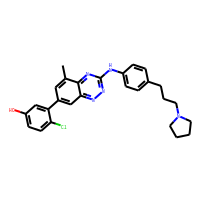
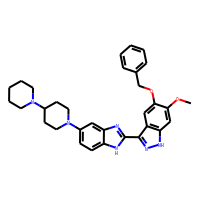
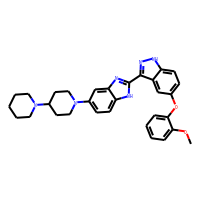
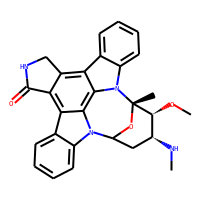
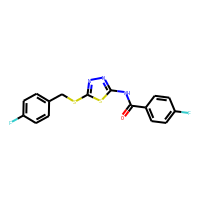
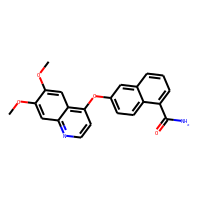
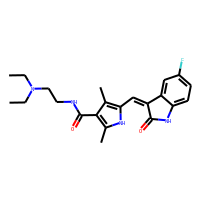
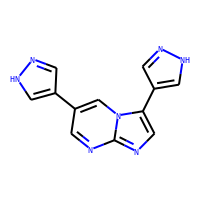
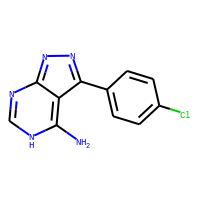

In [0]:
#Dropping our "duplicates" to see what our major cluster looks like
cluster_df= new_df.drop_duplicates("Cluster")
cluster_df

We can see that all the 9 clusters have similar scaffolds (compare 2 and 5). To see a more concrete similariy, we can construct a similarity map. Out of all molecules, I am interested in how other compounds fare against the first one

In [0]:
#Create a list for all of our smiles from the cluster
smiles= list(cluster_df["Smiles"])
smiles

['Cc4cc(c1cc(O)ccc1Cl)cc5nnc(Nc3ccc(CCCN2CCCC2)cc3)nc45',
 'COc6cc5[nH]nc(c4nc3cc(N2CCC(N1CCCCC1)CC2)ccc3[nH]4)c5cc6OCc7ccccc7',
 'COc1ccccc1Oc7ccc6[nH]nc(c5nc4cc(N3CCC(N2CCCCC2)CC3)ccc4[nH]5)c6c7',
 'CN[C@@H]1CC5O[C@@](C)([C@@H]1OC)n7c2ccccc2c8c3CNC(=O)c3c6c4ccccc4n5c6c78',
 'Fc3ccc(CSc2nnc(NC(=O)c1ccc(F)cc1)s2)cc3',
 'COc4cc3nccc(Oc2ccc1c(C(N)=O)cccc1c2)c3cc4OC',
 'CCN(CC)CCNC(=O)c3c(C)[nH]c(\\C=c1/c(=O)[nH]c2ccc(F)cc12)c3C',
 'c1n[nH]cc1c4cnc3ncc(c2cn[nH]c2)n3c4',
 'Nc2[nH]cnc3nnc(c1ccc(Cl)cc1)c23']

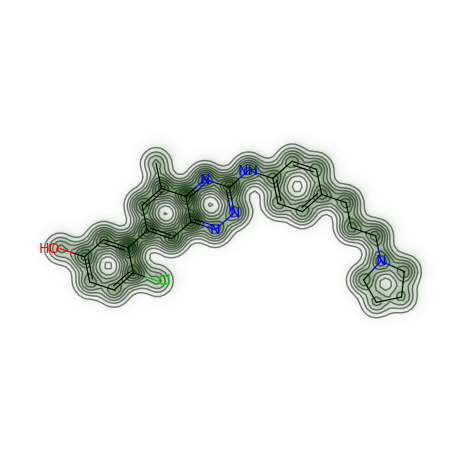

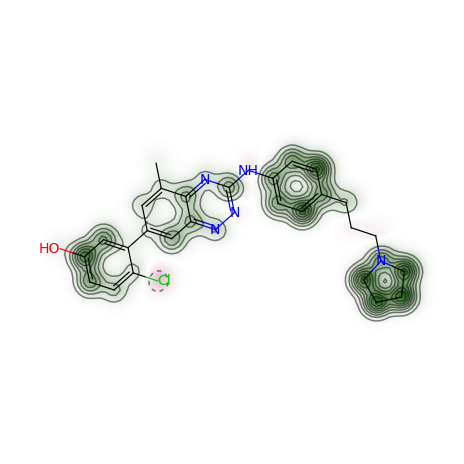

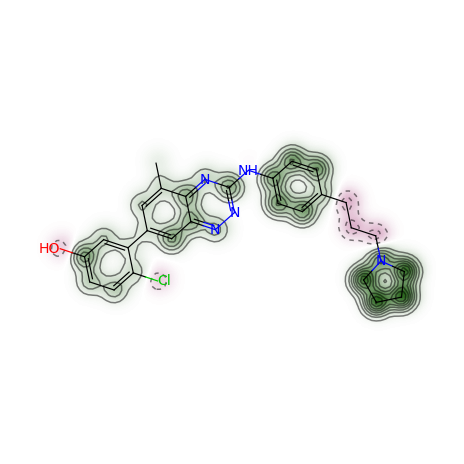

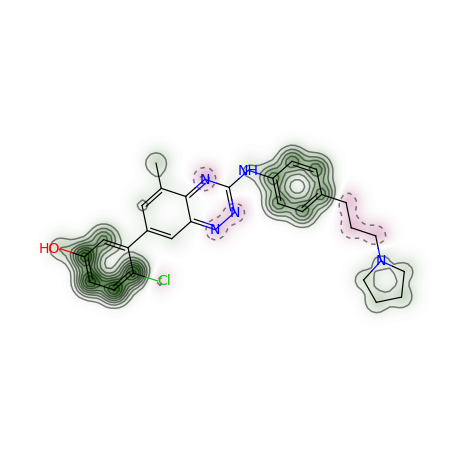

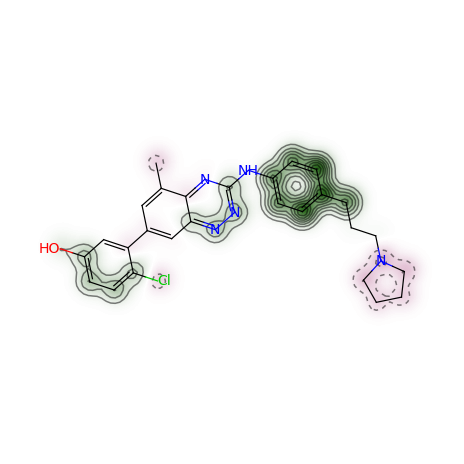

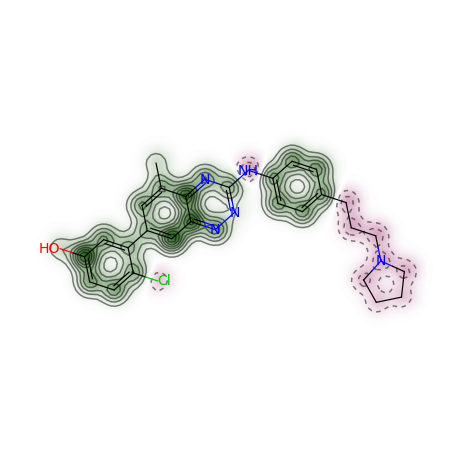

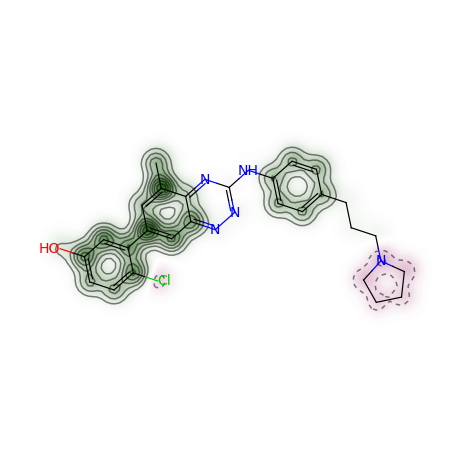

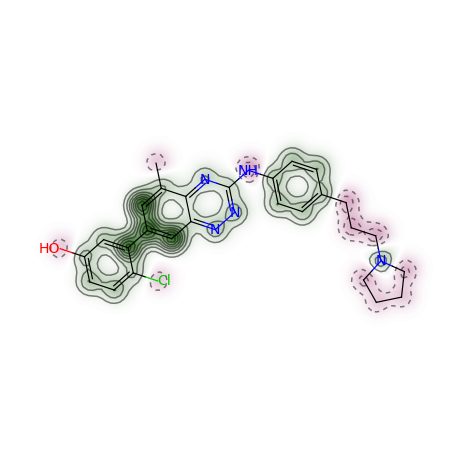

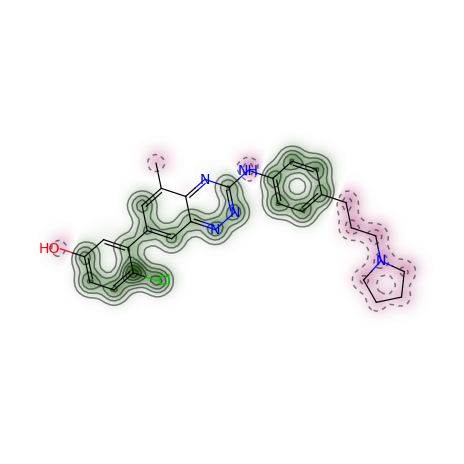

In [0]:
#Assigning the SMILES of the compound of the first cluster:
mol= Chem.MolFromSmiles('Cc4cc(c1cc(O)ccc1Cl)cc5nnc(Nc3ccc(CCCN2CCCC2)cc3)nc45')
for i in smiles:
  refmol= Chem.MolFromSmiles(i)
  fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint)

Looking at our similarity map, it seems that all of our cluster contains one scaffold in our compound of interest (for example, aniline and all of our phenyl substituent). Our pyrrolidine scaffold seems to be important as well, as a lot of our clusters contain heterocyclic nitrogen compounds. 

As mentioned before, our active compounds seem to be polar, to confirm our inference, we can check ligand interaction with our molecule through PDB:

https://www.rcsb.org/3d-view/1FPU?preset=ligandInteraction&sele=PRC

From pdb website, we can see that a lot of interactions involve polar interaction such as hydrogen bond, pi stacking and cation-pi interaction. 

In [0]:
#Create new function to add new columns that describe the properties

def add_property(df):
  df["mw"]= [Descriptors.MolWt(mol) for mol in df.Mol]
  df["logP"]= [Descriptors.MolLogP(mol) for mol in df.Mol]
  df["charge"]= [rdmolops.GetFormalCharge(mol) for mol in df.Mol]

add_property(active_df)
#We can check whether it is successful by printing the first 5 rows
print(active_df.head(5))

                                              Smiles      ID  ...     logP charge
0  Cc4cc(c1cc(O)ccc1Cl)cc5nnc(Nc3ccc(CCCN2CCCC2)c...  416908  ...  6.13122      0
1  CN(CCN1CCCC1)S(=O)(=O)c5ccc(Nc4nnc3cc(c2cc(O)c...  416918  ...  4.81912      0
2  CN5CCN(Cc4ccc(NC(=O)c3ccc(C)c(C#Cc1cnc2cccnn12...  649637  ...  4.45602      0
3  COc4cc(Nc2c(C#N)cnc3cc(\C=C\CCN1CCN(C)CC1)c(OC...  629071  ...  5.82478      0
4  COc5cc(Nc3c(C#N)cnc4cc(c2coc(CN1CCN(C)CC1)c2)c...  365326  ...  6.18148      0

[5 rows x 8 columns]


## Decoy Molecules
This section describes how to input our decoy molecules for our virtual screening.

<bound method NDFrame.head of                                                        0          1
0      C[C@@H]1CCCC[C@]12C(=O)N(C(=O)N2)CC(=O)Nc3ccc(...  C02649438
1      C=C1[C@H](C(=O)N(N1)c2nc3ccccc3s2)/C=N/C(CO)(C...  C01814196
2      CCOC(=O)C1=C(OC(=C([C@@H]1c2ccc(cc2)OCC(=O)N)C...  C00808935
3      CCOc1cc(ccc1O)[C@H]2c3c([nH]nc3O)C[C@@]([C@@H]...  C04908604
4      CCCCn1c(=O)c(c([nH]c1=S)O)C2=NN[C@@H](C2)c3ccc...  C15834792
...                                                  ...        ...
10745  CCOc1cc(ccc1OCc2ccc(cc2)F)/C=C/3\C(=O)N/C(=N/c...  C59105773
10746  CCOc1ccc(cc1)NC(=O)/C(=C/c2ccc(cc2)OCc3ccc(cc3...  C59297078
10747  CCOC(=O)c1c2c(sc1NC(=O)/C=C/c3ccc(o3)c4ccc(cc4...  C59399679
10748  CCOC(=O)c1c(csc1NC(=O)Cc2cn(c3c2cccc3)C)c4ccc(...  C62039268
10749  C[C@@H](c1ccc(cc1)CC(C)C)C(=O)Nc2ccc(cc2)S(=O)...  C66198706

[10750 rows x 2 columns]>


,Smiles,ID,label,Mol,mw,logP,charge
0,C[C@@H]1CCCC[C@]12C(=O)N(C(=O)N2)CC(=O)Nc3ccc(...,C02649438,Decoy,,358.398,1.22470,0
1,C=C1[C@H](C(=O)N(N1)c2nc3ccccc3s2)/C=N/C(CO)(C...,C01814196,Decoy,,362.411,0.06390,0
2,CCOC(=O)C1=C(OC(=C([C@@H]1c2ccc(cc2)OCC(=O)N)C...,C00808935,Decoy,,357.366,1.19548,0
3,CCOc1cc(ccc1O)[C@H]2c3c([nH]nc3O)C[C@@]([C@@H]...,C04908604,Decoy,,362.382,1.44780,0
4,CCCCn1c(=O)c(c([nH]c1=S)O)C2=NN[C@@H](C2)c3ccc...,C15834792,Decoy,,390.465,2.56449,0
...,...,...,...,...,...,...,...
10745,CCOc1cc(ccc1OCc2ccc(cc2)F)/C=C/3\C(=O)N/C(=N/c...,C59105773,Decoy,,466.509,5.83410,0
10746,CCOc1ccc(cc1)NC(=O)/C(=C/c2ccc(cc2)OCc3ccc(cc3...,C59297078,Decoy,,477.358,5.97248,0
10747,CCOC(=O)c1c2c(sc1NC(=O)/C=C/c3ccc(o3)c4ccc(cc4...,C59399679,Decoy,,455.963,6.36890,0
10748,CCOC(=O)c1c(csc1NC(=O)Cc2cn(c3c2cccc3)C)c4ccc(...,C62039268,Decoy,,460.599,6.38810,0

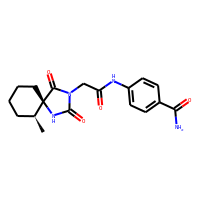
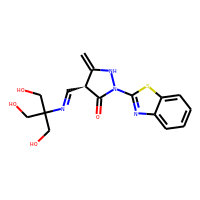
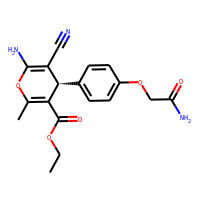
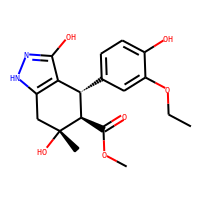
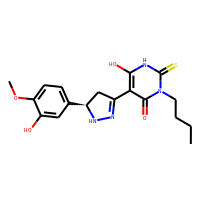
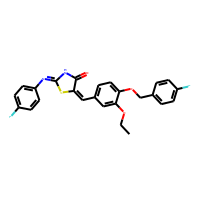
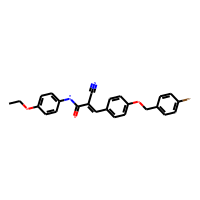
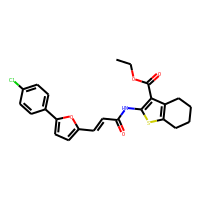
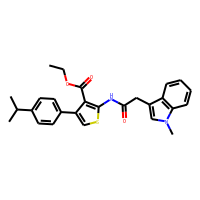
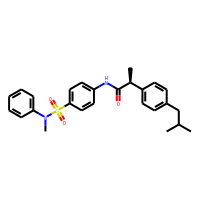

In [0]:
#The following steps are the same as our active molecules

decoy_df= pd.read_csv("decoys_final.ism", header= None, sep=" ")
print(decoy_df.head)
decoy_df.columns= ["Smiles", "ID"]
decoy_rows, decoy_cols= decoy_df.shape
decoy_df["label"]= ["Decoy"]*decoy_rows
PandasTools.AddMoleculeColumnToFrame(decoy_df, "Smiles", "Mol")
add_property(decoy_df)
decoy_df

Looking at our decoy molecules, a lot of them seem to have scaffold similar to our active molecules. A lot of them have methoxy, phenol, chloride groups that just by glancing at them, could be mistaken as active if we did not know if they were decoy if we are basing our drug design just by inference. This is why decoy molecules are useful to train our models

In [0]:
#Creating new dataframe
tmp_df= active_df.append(decoy_df)

## Visualizing data and properties of our active and decoy compounds

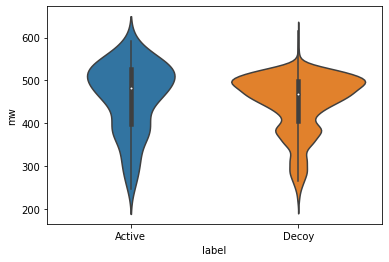

In [0]:
#Visualizing molecular weight
sns.violinplot(tmp_df["label"], tmp_df["mw"])

Looking at the distribution of our active and decoy molecules, they are somewhat similar with most molecules have molecular weight of 500 g/mol

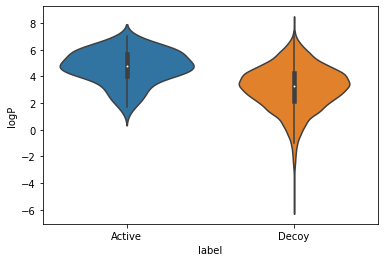

In [0]:
#LogP:
sns.violinplot(tmp_df["label"], tmp_df["logP"])

Our logP is also similar

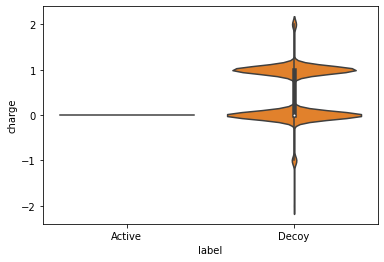

In [0]:
#Charge
sns.violinplot(tmp_df["label"], tmp_df["charge"])


It seems that our decoy nolecules have some charged molecules, we want to convert them into its neutral state. Luckily we can use the following code from rdkit (http://rdkit.org/docs_temp/Cookbook.html)

In [0]:
from rdkit import Chem
from rdkit.Chem import AllChem

def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(smiles, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    mol = Chem.MolFromSmiles(smiles)
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = AllChem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    if replaced:
        return (Chem.MolToSmiles(mol,True), True)
    else:
        return (smiles, False)

In [0]:
#Neutralizing decoy molecules by storing it in a temporary dataframe:
revised_decoy_df= decoy_df[["Smiles", "ID","label"]].copy()
revised_decoy_df["Smiles"]= [NeutraliseCharges(x)[0] for x in revised_decoy_df["Smiles"]]

In [0]:
PandasTools.AddMoleculeColumnToFrame(revised_decoy_df, "Smiles", "Mol")
#We add all the property columns to  our dataframe using the same function that have been defined before
add_property_columns_to_df(revised_decoy_df)


In [0]:
#We can see that a lot of our decoy molecules are now neutral
#We can also see what is our charge molecule and the ratio between charged and total molecules
#0.001% of our molecules are charged which is only a miniscule amount
charged= revised_decoy_df[revised_decoy_df["charge"]!=0]
print(len(charged)/revised_decoy_df.shape[0])

0.0017674418604651163


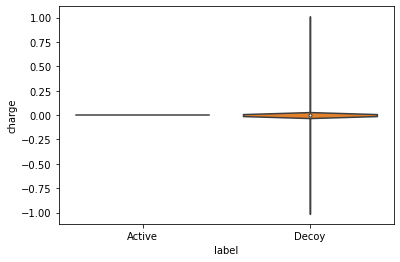

In [0]:
#We create new temp dataframe that has both our revised decoy and our active
new_tmp_df= active_df.append(revised_decoy_df)
sns.violinplot(new_tmp_df["label"], new_tmp_df["charge"])


We can see that both our active and decoy molecules are neutral. We can proceed to training our model

In [0]:
active_df["is_active"]= [1]*active_df.shape[0]
revised_decoy_df["is_active"]= [0]*revised_decoy_df.shape[0]
#Combining the dataframes with all the necessary columns for the next step
combined_df= active_df.append(revised_decoy_df)[["Smiles", "ID", "is_active"]]
print(combined_df.head())

                                              Smiles      ID  is_active
0  Cc4cc(c1cc(O)ccc1Cl)cc5nnc(Nc3ccc(CCCN2CCCC2)c...  416908          1
1  CN(CCN1CCCC1)S(=O)(=O)c5ccc(Nc4nnc3cc(c2cc(O)c...  416918          1
2  CN5CCN(Cc4ccc(NC(=O)c3ccc(C)c(C#Cc1cnc2cccnn12...  649637          1
3  COc4cc(Nc2c(C#N)cnc3cc(\C=C\CCN1CCN(C)CC1)c(OC...  629071          1
4  COc5cc(Nc3c(C#N)cnc4cc(c2coc(CN1CCN(C)CC1)c2)c...  365326          1


In [0]:
combined_df.to_csv("dude_abl.csv", index= False) #This will save into virtual machine
#To save your file to your local machine, I use google colab so this is what I do:
from google.colab import files
files.download("dude_abl.csv")